In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from utils import get_loader
from torchvision import transforms
from model import EncoderCNN, DecoderRNN

%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
# plt.switch_backend('TKAgg')

### 1. 获取测试数据集的数据加载器

Vocabulary successfully loaded from vocab.pkl file!


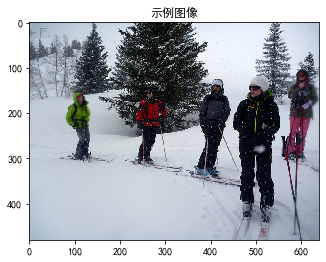

In [35]:
# 在transform_test中定义要用于预处理测试图像的转换
# 需要和训练数据的内容保持一致
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # get 224x224 crop from random location
    transforms.ToTensor(),  # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),  # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Create the data loader.
data_loader = get_loader(transform=transform_test,
                         mode='test')

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# 示例测试图像可视化
# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('示例图像')
plt.show()

### 2.加载训练模型

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [37]:
# 模型权重名字
encoder_file = 'encoder-1.pkl'
decoder_file = 'decoder-1.pkl'

# 和训练模型时候的时候一致
embed_size = 1024
hidden_size = 1024

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()

decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))    

<All keys matched successfully>

In [38]:
# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embeddings): Embedding(8856, 1024)
  (lstm): LSTM(1024, 1024, batch_first=True)
  (fc): Linear(in_features=1024, out_features=8856, bias=True)
)

### 3.取样器

In [39]:
# DecoderRNN类的sample方法。
# 输入：对应于单个图像的嵌入输入特征的PyTorch张量features。
# 输出，返回一个Python列表output，用于指示预测的语句。output[i]是一个非负整数，用于标识句子中预测的第i个标记。
# 可以通过检查data_loader.dataset.vocab.word2idx 或 data_loader.dataset.vocab.idx2word来探索整数和标记之间的对应关系。

image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# 输出描述实例图片的整数列表
# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('示例图像描述的整数列表:', output)

示例图像描述的整数列表: [0, 3, 80, 13, 51, 139, 319, 39, 3, 318, 1400, 1]


### 4.清理标注，把整数列表转换成文字

In [40]:
# 把一个整数列表（对应于Step 3中的变量output）作为输入并返回相应的预测语句（作为单个Python字符串）。
def clean_sentence(output):
    sentence_list = []

    for idx in output:
        sentence_list.append(data_loader.dataset.vocab.idx2word[idx])

    sentence_list = sentence_list[1:-1]
    sentence = ' '.join(sentence_list)
    sentence = sentence.capitalize()

    return sentence

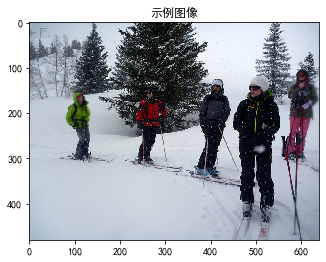

示例图像描述的文字: A group of people riding skis on a snowy surface


In [41]:
plt.imshow(np.squeeze(orig_image))
plt.title('示例图像')
plt.show()
print('示例图像描述的文字:', clean_sentence(output))

### 5.生成预测函数

In [42]:
# get_prediction函数，遍历测试数据集中的图像并输出模型的预测描述。
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)
    sentence = clean_sentence(output)

    print(sentence)

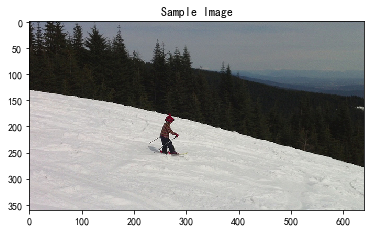

A man riding skis down a snow covered slope .


In [43]:
# 可以尝试多次运行，查看模型效果
get_prediction()

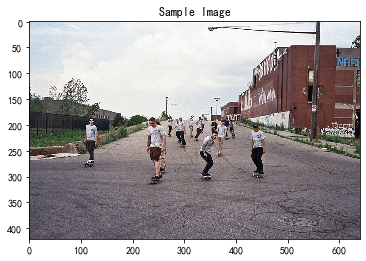

A group of people riding on a street .


In [44]:
# 可以尝试多次运行，查看模型效果
get_prediction()

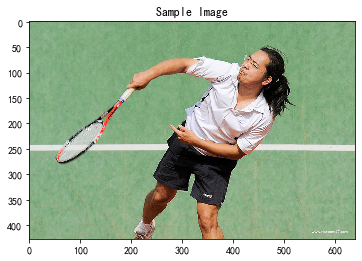

A man holding a tennis racket on a court .


In [45]:
# 可以尝试多次运行，查看模型效果
get_prediction()